Most similar topics for all DUC2006 + DUC2007 topics
===

Disclaimer. I use python 2.7, so take care if you use something else...

In [1]:
import numpy as np
import os
from os import path
from gensim.models import KeyedVectors
import codecs
from scipy.spatial.distance import cosine
import scipy
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


from sklearn import decomposition
from sklearn import datasets

C:\bin\anaconda\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def load_w2v_by_name(embeddings_path = path.abspath(path.normpath(path.join(path.expanduser("~"), ".ukpsummarizer","embeddings"))), variant="google.neg.300d"):
    binary = True
    embeddings={}
    if variant == "google.neg.300d":
        embeddPath = path.normpath(path.join(embeddings_path, "english/GoogleNews-vectors-negative300.bin.gz"))
        embeddData = path.normpath(path.join(embeddings_path, "english/data/"))
        vocab_size = 3000000
        embedding_size = 300
    elif variant == "glove.6B.300d":
        embeddPath = path.normpath(path.join(embeddings_path, "english/glove/glove.6B.300d.txt.w2v"))
        embeddData = path.normpath(path.join(embeddings_path, "english/glove/glove.6B.300d/"))
        vocab_size = 400000
        embedding_size = 300
        binary=False
    elif variant == "tudarmstadt_german":
        embeddPath = path.normpath(path.join(embeddings_path, "german/2014_tudarmstadt_german_50mincount.vec"))
        embeddData = path.normpath(path.join(embeddings_path, "german/data/"))
        vocab_size = 648460
        embedding_size = 100
    else:
        raise ValueError("Embeddings variant unknown. was %s" % (variant))

    if not path.exists(embeddData):
        os.makedirs(embeddData)
    embeddings = LoadEmbeddings(filepath=embeddPath, data_path=embeddData, vocab_size=vocab_size,
                                    embedding_size=embedding_size, binary_val=binary)
    return embeddings


In [3]:
class LoadEmbeddings():
    def __init__(self, filepath, data_path, vocab_size, embedding_size=300, binary_val=True):
        self.vocab_dict = {}
        self.embedding_size = embedding_size
        _, self.embedding_variant = os.path.split(data_path)
        self.loadEmbeddings(filepath, data_path, vocab_size, binary_val)
       
    def convertToNumpy(self, vector):
        return np.array([float(x) for x in vector])

    def loadEmbeddings(self, filepath, data_path, vocab_size, binary_val):
        embed_short = os.path.normpath("%s/embed.dat" % data_path)
        if not path.exists(embed_short):
            print("Caching word embeddings in memmapped format...")
            print(binary_val, filepath)
            wv = KeyedVectors.load_word2vec_format("%s" % (filepath), binary=binary_val)
            fp = np.memmap(embed_short, dtype=np.double, mode='w+', shape=wv.syn0.shape)
            fp[:] = wv.syn0[:]
            with open(os.path.normpath("%s/embed.vocab" % data_path), "w") as fp:
                for _, w in sorted((voc.index, word) for word, voc in wv.vocab.items()):
                    fp.write("%s\n"%(w.encode("utf8")))
            del fp, wv
            
        self.W = np.memmap(os.path.normpath("%s/embed.dat" % data_path), dtype=np.double, mode="r", shape=(vocab_size, self.embedding_size))
        with codecs.open(os.path.normpath("%s/embed.vocab" % data_path), 'r', 'utf-8') as f:
            vocab_list = [x.strip() for x in f.readlines()]
        self.vocab_dict = {w: k for k, w in enumerate(vocab_list)}

    def word2embedd(self, word):
        word = word.lower()
        if word in self.vocab_dict:
            return self.W[self.vocab_dict[word]]
        else:
            return self.W[self.vocab_dict["unknown"]]
    
    def isKnown(self, word):
        word = word.lower()
        return word in self.vocab_dict

In [4]:

class ConceptEmbedder():
    def __init__(self, word_embeddings):
        self.word_embeddings = word_embeddings
        self.cache = {}
        self.errorcount = 0

    def __call__(self, words):
        """

        :param concept: str representing the concept
        :return: vectorial representation of the concept
        @type concept: list[str]
        """
        key = " ".join(sorted(words))

        w2v = self.word_embeddings
        vector = np.zeros(w2v.embedding_size)
        if not self.cache.has_key(key):
            for word in words:
                if w2v.isKnown(word):
                    lookup = w2v.word2embedd(word.lower())
                    vector += lookup
                else:
                    # print("unknown word:", word)
                    self.errorcount += 1
            vector = vector / len(words)
            self.cache[key] = vector
        return self.cache[key]

In [5]:
# if the embeddings are stored somewhere else than in the dedicated directory, 
# load_w2v does also provide another parameter that can be used to modify the behaviour
embeddings = load_w2v_by_name(variant="glove.6B.300d")


In [6]:
ce = ConceptEmbedder(embeddings)

Now lets do some basics on texts
===

In [7]:
"The quick brown fox jumped over the lazy dog".split(" ")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [8]:
sorted("The quick brown fox jumped over the lazy dog".split(" "))

['The', 'brown', 'dog', 'fox', 'jumped', 'lazy', 'over', 'quick', 'the']

In [9]:
# linear algebra on "concepts"
ce("The quick brown fox jumped over the lazy dog".split(" ")) - ce(["The fox jumped over the dog"])

array([  1.21909223e-01,   1.35285671e-01,   1.39752801e-01,
        -4.35483288e-02,  -8.60822226e-02,   4.38363116e-02,
        -1.21829332e-01,   1.80647128e-01,  -5.93104410e-02,
        -9.08563325e-01,  -3.03011106e-02,   4.00875546e-02,
        -5.95935520e-02,   9.22417734e-02,   1.97259559e-01,
         3.21292220e-01,  -7.10773369e-02,  -2.02426679e-02,
         5.92651106e-02,   1.68485338e-01,   5.59723332e-02,
         2.22094440e-01,   1.12270001e-01,   5.58242251e-02,
        -4.32286660e-02,  -1.19493221e-01,   1.73399555e-01,
        -1.39611333e-01,  -3.19932269e-02,  -2.86771131e-02,
        -1.70436554e-01,   1.34668442e-01,  -8.54899966e-02,
         7.48436720e-02,  -9.98553329e-01,   1.68676214e-01,
         6.42001980e-02,  -1.48323367e-02,  -1.44199334e-01,
         1.20946331e-01,  -1.87562220e-01,   6.11601091e-02,
        -1.59342190e-02,   1.44913332e-01,   1.76958581e-01,
        -5.15774457e-02,   1.82168576e-01,  -3.27867789e-02,
        -8.13449981e-02,

In [10]:
cosine(ce("The quick brown fox jumped over the lazy dog".split(" ")), ce("The brown fox jumped over the lazy dog".split(" ")))

0.015085811937704863

In [11]:
cosine(ce("The quick brown fox jumped over the lazy dog".split(" ")), ce("The brown fox jumped over the dog".split(" ")))

0.046772919681685732

In [12]:
cosine(ce("The quick brown fox jumped over the lazy dog".split(" ")), ce("The fox jumped over the dog".split(" ")))

0.074656596332149272

In [13]:
cosine(ce("The quick brown fox jumped".split(" ")), ce("jumped over the lazy dog".split(" ")))

0.2627298484901659

Example creation of distance matrix from strings
===

In [14]:
titles = ["incremental self improvement for life time multi agent reinforcement learning",
          "incremental self improvement for life time multi agent active learning",
          "incremental self improvement",
          "an intrinsic neuromodulation model for realizing anticipatory behavior in reaching movement under unexperienced force fields"]

In [15]:
vectors = [ce(title) for title in titles]

In [16]:
# calculate the condensed distance matrix. Beware, it really is the DISTANCE, not the similarity.
cdm = scipy.spatial.distance.pdist(vectors, "cosine")

In [17]:
# to have a "nice" distance matrix, we need to convert the condensed DM into squarified form
sdm = scipy.spatial.distance.squareform(cdm)

In [18]:
sdm

array([[ 0.        ,  0.00260969,  0.00426843,  0.01266565],
       [ 0.00260969,  0.        ,  0.00686652,  0.01652671],
       [ 0.00426843,  0.00686652,  0.        ,  0.02066607],
       [ 0.01266565,  0.01652671,  0.02066607,  0.        ]])

In [19]:
m = round(np.min(cdm), 3)+0.001
res = np.where(sdm<=m)

In [20]:
res

(array([0, 0, 1, 1, 2, 3], dtype=int64),
 array([0, 1, 0, 1, 2, 3], dtype=int64))

Because of the fact that the diagonal is zero, those are also included in the result. So the only values of interest in the `res` object are those where the value at the same index in both array differ.

In [21]:
titles[0]

'incremental self improvement for life time multi agent reinforcement learning'

In [22]:
titles[1]

'incremental self improvement for life time multi agent active learning'

Distance matrix for all DUC2006 + DUC2007 topics
===


In [77]:
p = path.abspath(path.normpath(path.join(".","cosine-on-titles", "duc2006+2007-titles.json")))

In [80]:
df = pd.read_json(p)

In [134]:
df.head()

,narrative,title,topic
0,Describe the activities of Morris Dees and the...,Southern Poverty Law Center,D0701A
1,Describe the state of teaching art and music i...,art and music in public schools,D0702A
2,Describe steps taken and worldwide reaction pr...,steps toward introduction of the Euro,D0703A
3,What is the scope of operations of Amnesty Int...,Amnesty International,D0704A
4,Describe developments in the Basque separatist...,Basque separatism,D0705A


In [97]:
titles = df["narrative"]

In [98]:
vectors = [ce(title) for title in titles]

In [99]:
len(vectors)

95

In [100]:
cdm = scipy.spatial.distance.pdist(vectors, "cosine")

In [101]:
cdm

array([ 0.01107617,  0.00889932,  0.01901875, ...,  0.01350454,
        0.00913677,  0.01224441])

In [172]:
sdm = scipy.spatial.distance.squareform(cdm)
np.fill_diagonal(sdm, np.inf) # fill diagonal with +inf to prevent those cells as minimae

In [173]:
m = round(np.min(cdm), 3)+0.003
res = np.where(sdm<=m)

In [174]:
np.min(cdm)

0.0022595627059192047

In [175]:
np.max(cdm)

0.048704971954069087

In [176]:
np.where(cdm<0.01)

(array([   1,    5,    8, ..., 4453, 4457, 4463], dtype=int64),)

In [177]:
np.min(sdm)

0.0022595627059192047

In [178]:
np.max(sdm)

inf

In [179]:
sdm.argmin(axis=0)

array([13, 67, 81, 78, 44, 45, 52, 39, 22, 36, 71, 15,  3, 73, 69, 82,  1,
        1, 51, 59,  1, 84,  8, 91, 48, 26, 85, 46, 13, 91, 12, 53, 24, 56,
       13, 44, 73, 15, 49,  1, 12, 90, 51, 55, 35, 16, 85, 49, 24, 47, 10,
       59,  6, 31, 70,  1, 53, 13, 52, 51, 53, 26, 28, 82, 82, 90, 34,  1,
       51, 14, 81, 10, 20, 13, 82,  1,  3,  1,  3, 51, 15, 70, 63, 89, 21,
       26,  6, 51, 34, 83, 79, 29,  0, 70, 13], dtype=int64)

In [180]:
np.transpose(np.where(sdm<0.003))

array([[ 0, 13],
       [ 1, 67],
       [13,  0],
       [13, 73],
       [14, 69],
       [29, 91],
       [31, 53],
       [51, 59],
       [53, 31],
       [59, 51],
       [63, 82],
       [67,  1],
       [69, 14],
       [73, 13],
       [82, 63],
       [83, 89],
       [89, 83],
       [91, 29]], dtype=int64)

In [161]:
for u in np.transpose(np.where(sdm<0.003)):
    print df.iloc[[ u[0], u[1]]]["topic"]

0     D0701A
13    D0714D
Name: topic, dtype: object
1     D0702A
67    D0623E
Name: topic, dtype: object
13    D0714D
0     D0701A
Name: topic, dtype: object
13    D0714D
73    D0629B
Name: topic, dtype: object
14    D0715D
69    D0625G
Name: topic, dtype: object
29    D0730G
91    D0647B
Name: topic, dtype: object
31    D0732H
53    D0609I
Name: topic, dtype: object
51    D0607G
59    D0615F
Name: topic, dtype: object
53    D0609I
31    D0732H
Name: topic, dtype: object
59    D0615F
51    D0607G
Name: topic, dtype: object
63    D0619A
82    D0638B
Name: topic, dtype: object
67    D0623E
1     D0702A
Name: topic, dtype: object
69    D0625G
14    D0715D
Name: topic, dtype: object
73    D0629B
13    D0714D
Name: topic, dtype: object
82    D0638B
63    D0619A
Name: topic, dtype: object
83    D0639C
89    D0645I
Name: topic, dtype: object
89    D0645I
83    D0639C
Name: topic, dtype: object
91    D0647B
29    D0730G
Name: topic, dtype: object


In [162]:
df.iloc[np.where(sdm<0.003)[0],np.where(sdm<0.003)[1]]

IndexError: positional indexers are out-of-bounds

In [130]:
np.where(sdm<0.0)[0]

array([ 0,  0,  0, ..., 94, 94, 94], dtype=int64)

In [181]:
df.iloc[[0,13,73]]

,narrative,title,topic
0,Describe the activities of Morris Dees and the...,Southern Poverty Law Center,D0701A
13,Describe the legal battle between various reco...,Napster,D0714D
73,Identify computer viruses detected worldwide. ...,computer viruses,D0629B


In [116]:
df.iloc[[53,64]]

,narrative,title,topic
53,What impact have Israeli settlements in the We...,Israeli West Bank settlements,D0609I
64,Discuss measures that schools and school distr...,school violence prevention measures,D0620B


In [117]:
df.iloc[[62,64]]

,narrative,title,topic
62,What efforts are being made to combat the spre...,malaria prevention and treatment,D0618I
64,Discuss measures that schools and school distr...,school violence prevention measures,D0620B


Project the distance matrix in lower dimensions
===

In [118]:
dmf = pd.DataFrame(sdm)

In [120]:
pcasdm = np.fill_diagonal(sdm, 0.0)
pca = decomposition.PCA(n_components=2)
pca.fit(sdm)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [121]:
x = pca.transform(sdm)

In [122]:
pcadf = pd.DataFrame(x, columns=["x","y"])

In [123]:
pcadf.plot.scatter(x="x",y="y")

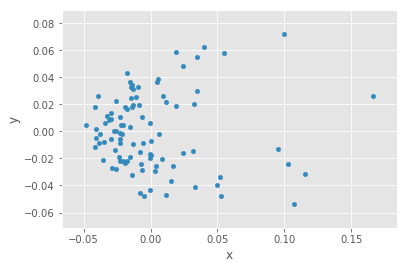

In [124]:
plt.show()

Weather and climate cluster
===

In [142]:
df.loc[df["topic"] == "D0641E"]

,narrative,title,topic
85,Describe theories concerning the causes and ef...,global warming,D0641E


In [145]:
df.loc[df["topic"] == "D0643G"]

,narrative,title,topic
87,Describe the causes and effects of the El Nino...,El Nino and La Nina weather condition,D0643G


In [146]:
sdm[85][87]

0.0054456245126162095